In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tqdm import trange , tqdm

tqdm.pandas()

import pandas as pd
import cv2

import torch
from torchvision import transforms


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Set up paths

In [34]:
data_path = os.path.abspath(os.path.join( os.getcwd(), ".." , 'data'))
train_path = os.path.join( data_path ,  'train_images','train')
test_path = os.path.join( data_path , 'test_images')
train_im_files = os.listdir(train_path)

# I. Data exploration and Augmentation 

In [17]:
df = pd.read_csv(os.path.join(data_path , 'train_no_defect.csv'))

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12997 entries, 0 to 12996
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        12997 non-null  object
 1   ClassId        12997 non-null  int64 
 2   EncodedPixels  12997 non-null  object
dtypes: int64(1), object(2)
memory usage: 304.7+ KB


## - Seperating train and validation sets

In [20]:
train_list = []
textfile = open(os.path.join(data_path,"train_list_augmented_final.txt"), "r")
for element in textfile:
    train_list.append(element[:-1])
textfile.close()

df['train'] = np.where(df['ImageId'].isin(train_list) , True , False )
df['train'].value_counts(normalize=True)

True     0.812495
False    0.187505
Name: train, dtype: float64

## 1. Augmentation that has the same mask as original :
### 1.a Brightness, Contrast and Saturation

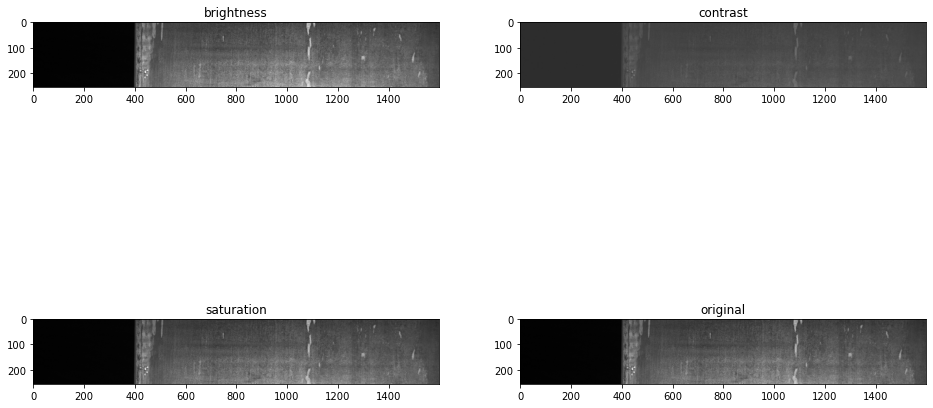

In [24]:
img0 = PIL.Image.open(os.path.join(train_path,train_im_files[-3]))
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

# original
ax[1, 1].set_title(f'original')
ax[1, 1].imshow(img0)

# brightness
loader_transform1 = transforms.ColorJitter(brightness=1.5)
img1 = loader_transform1(img0)
ax[0, 0].set_title(f'brightness')
ax[0, 0].imshow(img1)

# contrast
loader_transform2 = transforms.ColorJitter(contrast=2)
img2 = loader_transform2(img0)
ax[0, 1].set_title(f'contrast')
ax[0, 1].imshow(img2)

# saturation
loader_transform3 = transforms.ColorJitter(saturation=2)
img3 = loader_transform3(img0)
ax[1, 0].set_title(f'saturation')
ax[1, 0].imshow(img3)




plt.show()

### 1.b Applying changes to train set only images

In [25]:
def color_augmentation(df):
    for im_id in df.loc[df['train'],'ImageId'].tolist():
        img = PIL.Image.open(os.path.join(train_path,im_id))
        
        deg = np.random.uniform(0, 1)+1
        
        loader_transform1 = transforms.ColorJitter(brightness=deg)
        loader_transform2 = transforms.ColorJitter(contrast=deg)
        loader_transform3 = transforms.ColorJitter(saturation=deg)
        
        img_b = loader_transform1(img)
        img_c = loader_transform2(img_b)
        img_s = loader_transform3(img_c)
        
        img_s.save(os.path.join(train_path,im_id[:-4] + '_bcs.jpg'))

## 2. Augmentation that keeps same shape but changes mask position :
### 2.a Flipping and 180° Rotation

In [26]:
df_hflip , df_vflip , df_rot = df[df['train']] , \
                               df[df['train']] , \
                               df[df['train']]

df_hflip['ImageId'] = df_hflip['ImageId'].apply(lambda x : x[:-4] + '_hf.jpg' )
df_vflip['ImageId'] = df_vflip['ImageId'].apply(lambda x : x[:-4] + '_vf.jpg' )
df_rot['ImageId'] = df_rot['ImageId'].apply(lambda x : x[:-4] + '_rot.jpg' )

<ipython-input-26-a8abbc3b27a2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hflip['ImageId'] = df_hflip['ImageId'].apply(lambda x : x[:-4] + '_hf.jpg' )
<ipython-input-26-a8abbc3b27a2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vflip['ImageId'] = df_vflip['ImageId'].apply(lambda x : x[:-4] + '_vf.jpg' )
<ipython-input-26-a8abbc3b27a2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

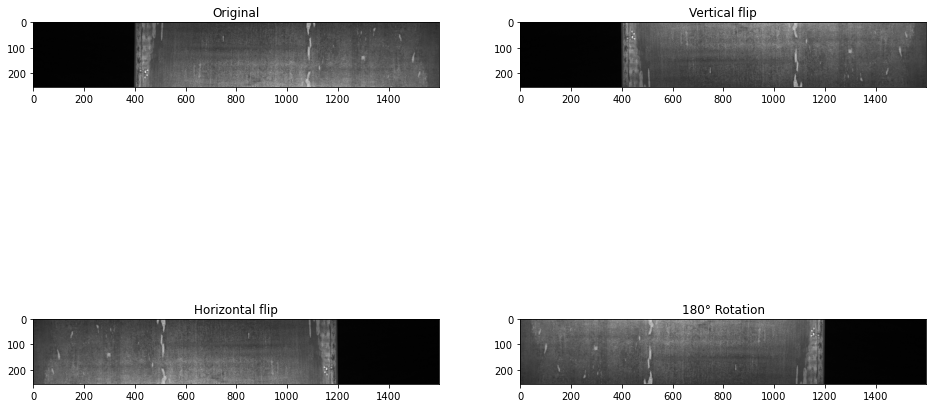

In [29]:
img0 = PIL.Image.open(os.path.join(train_path,train_im_files[-3]))
fig, ax = plt.subplots(2, 2, figsize=(16, 10))


# original
ax[0, 0].set_title(f'Original')
ax[0, 0].imshow(img0)


# Horizontal flip
loader_transform1 = transforms.RandomHorizontalFlip(p=1)
img1 = loader_transform1(img0)
ax[1, 0].set_title(f'Horizontal flip')
ax[1, 0].imshow(img1)

# Vertical Flip
loader_transform2 = transforms.RandomVerticalFlip(p=1)
img2 = loader_transform2(img0)
ax[0, 1].set_title(f'Vertical flip')
ax[0, 1].imshow(img2)

# 180 rotation
img3 = transforms.functional.rotate(img0,180)
ax[1, 1].set_title(f'180° Rotation')
ax[1, 1].imshow(img3)


plt.show()

In [40]:
def h_v_flip_rot(df):
    img_ids = df.loc[df['train'],'ImageId'].tolist()
    for i in trange(len(img_ids)):
        img = PIL.Image.open(os.path.join(train_path,img_ids[i]))
        
        hflip = transforms.RandomHorizontalFlip(p=1)
        img_hf = hflip(img)
        
        vflip = transforms.RandomVerticalFlip(p=1)
        img_vf = vflip(img)
        
        img_rot = transforms.functional.rotate(img,180)
        
        img_hf.save(os.path.join(train_path,img_ids[i][:-4] + '_hf.jpg'))
        img_vf.save(os.path.join(train_path,img_ids[i][:-4] + '_vf.jpg'))
        img_rot.save(os.path.join(train_path,img_ids[i][:-4] + '_rot.jpg'))

In [41]:
h_v_flip_rot(df)

100%|██████████████████████████████████████████████████████████████████████████████| 5806/5806 [08:22<00:00, 11.56it/s]


### 2.b Ajusting masks and adding data to train.csv

In [31]:
def compute_mask_aug( encoded_pixels , imshape = (1600,250)):
    width, height = imshape
    
            
    mask = np.zeros(width * height, dtype=np.uint8) # creating the mask matrix to fill later
    pixel_loc = np.array(list(map(int,encoded_pixels.split()))) #formatting pixels into array
    
    mask_loc = pixel_loc[0::2] # starting from zero and skipping every other pixel (numbers in even location)
    mask_len = pixel_loc[1::2] # starting from one and skipping every other pixel (numbers in odd location)
    
    for loc, length in zip(mask_loc, mask_len):
        mask[loc : loc+length] = 1 # binary mask
        
    mask = np.flipud(np.rot90(mask.reshape((width, height))))
    return mask

In [32]:
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')

    last_elem = 0
    running_length = 0

    for i, elem in enumerate(binary_mask.ravel(order='F')):
        if elem == last_elem:
            pass
        else:
            counts.append(running_length)
            running_length = 0
            last_elem = elem
        running_length += 1

    counts.append(running_length)
    rle['counts'] = ' '.join([ str(x) for x in rle['counts']])
    return rle['counts']

In [33]:
def ajust_mask_to_augmentation( encoded_pixels , aug_type):
    # compute mask for the image
    mask = compute_mask_aug(encoded_pixels)
    
    if aug_type == 'vf':
        mask = np.flipud(mask)
    elif aug_type == 'hf':
        mask = np.fliplr(mask)
    elif aug_type == 'rot':
        mask = np.rot90(mask,2)
        
    rle = binary_mask_to_rle(mask)
    
    return rle
    

In [ ]:
df_hflip['EncodedPixels_new'] = df_hflip['EncodedPixels'].progress_apply(lambda x : ajust_mask_to_augmentation(x , 'hf') )
df_hflip.to_csv(os.path.join(data_path,"train_hflip.csv"))

In [ ]:
df_vflip['EncodedPixels_new'] = df_vflip['EncodedPixels'].progress_apply(lambda x : ajust_mask_to_augmentation(x , 'vf') )
df_vflip.to_csv(os.path.join(data_path,"train_vflip.csv"))

In [44]:
df_rot['EncodedPixels_new'] = df_rot['EncodedPixels'].progress_apply(lambda x : ajust_mask_to_augmentation(x , 'rot') )
df_rot.to_csv(os.path.join(data_path,"train_rot.csv"))

100%|██████████████████████████████████████████████████████████████████████████████| 5806/5806 [39:40<00:00,  2.44it/s]


In [ ]:
def rename_col(x):
    return x[['ImageId','ClassId','EncodedPixels_new','train']].rename(columns={'EncodedPixels_new':'EncodedPixels'})

In [ ]:
df_hflip = rename_col(df_hflip)
df_vflip = rename_col(df_vflip)
df_rot = rename_col(df_rot)

df_aug = pd.concat([df_hflip , df_vflip , df_rot] )

In [ ]:
df_final = pd.concat([df_aug , df])

In [ ]:
df_final.to_csv(os.path.join(data_path,"train_final_add_non_defect.csv"))

# Mask computation and alphablend display

In [69]:
def compute_mask(row , imshape = (1600,250)):
    width, height = imshape
    
    mask = np.zeros(width * height, dtype=np.uint8) # creating the mask matrix to fill later
    pixel_loc = np.array(list(map(int,row.EncodedPixels.split()))) #formatting pixels into array
    
    mask_loc = pixel_loc[0::2] # starting from zero and skipping every other pixel (numbers in even location)
    mask_len = pixel_loc[1::2] # starting from one and skipping every other pixel (numbers in odd location)
    
    for loc, length in zip(mask_loc, mask_len):
        mask[loc : loc+length] = 255 # white in grayscale
        
    mask = np.flipud(np.rot90(mask.reshape((width, height))))
    return mask

In [75]:
def show_alphablend_image(imageid , df):
    image_fpath = os.path.join(train_path , imageid)
    row_ids = df.loc[df.ImageId == imageid,:].index.tolist()
    #colour for each ClassId :
    colours = {1 : (1,0,0) , 2 : (0,1,0) , 3 :(0,0,1) , 4 : (1,0,1) ,
               0 : (0,0,0)}
    
    alpha_blend = None
    for row_id in row_ids :
        row = df.iloc[row_id]
        
        im = cv2.imread(image_fpath)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        
        if not isinstance(alpha_blend , np.ndarray) :
            alpha_blend=im
        
        height, width , _ = im.shape 
        mask = compute_mask( row , (width,height) )
        
        colour = colours[row.ClassId]
        
        mask = np.transpose(np.array([mask.T*colour[0] , mask.T*colour[1] , mask.T*colour[2]]))

        
        alpha_blend = cv2.addWeighted(mask, 0.3, alpha_blend, 0.7, 0)
        
    return alpha_blend

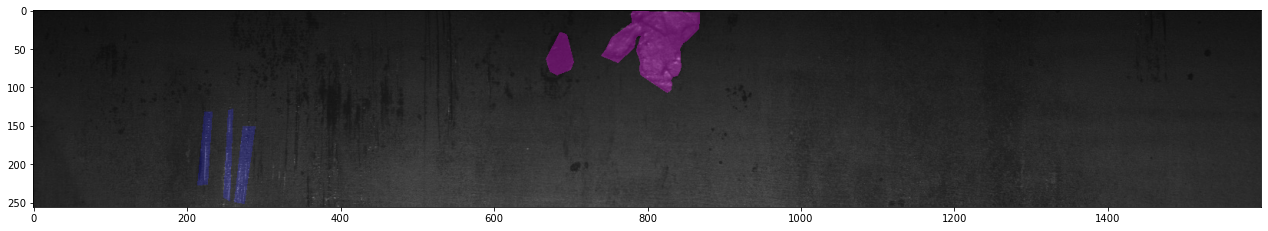

In [83]:
image = show_alphablend_image('edfe6ee4c.jpg' , df)
fig, axis = plt.subplots(figsize=(22, 8))
axis.imshow(image)
plt.show()